In [1]:
# be noted on the required versions:lumicks.pylake==0.8.1 tabulate==0.8.6; python 3.9
# python==3.9; jupyterlab==3.0.12; lumicks.pylake==0.8.1; matplotlib==3.3.4; more-itertools==8.7.0;
# npTDMS==1.1.0; numpy==1.20.1; opencv-python==4.5.1.48; pandas==1.2.3; scipy==1.6.1; tifffile==2021.3.5
import os
import numpy as np
import lumicks.pylake as lk  
import cv2
import pylab as pl
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import collections  as mc
from matplotlib import colors as mcolors
import pandas as pd
from nptdms import TdmsFile
from scipy.signal import savgol_filter
import tifffile as tif
from scipy import interpolate
from scipy.interpolate import interp1d
%matplotlib widget
# %matplotlib inline

In [2]:
# read raw image data of .tdms file with TdmsFile function
# name example: /Users/longfu/Library/CloudStorage/Dropbox/4-T7DNAp-SSB_NSMB/Figure2_imaging data_collected_Feb &Nov_2020_analyzed_May2023/1-Thesis writing analyzing 20 molecules_23may2023/20200121-012_typical data analysis/raw data/image data/20200121-140146 6nM gp2.5-atto647N + 144nM wt gp2.5 + 30nM DNAp and etal #012-001.tdms
kymo_filename = input('please type in the file name:' )

In [3]:
kymo_cycle = str('#') + input('please type in the processing cycle(e.g: 1):' )

In [4]:
# access .tdms file and convert .tdms to image data
metadata = TdmsFile.read_metadata(kymo_filename)
# print(metadata.properties)
width = metadata.properties['Pixels per line']
px_size = float(metadata.properties['Scan Command.Scan Command.scanning_axes.0.pix_size_nm'])
px_dwell_time = float(metadata.properties['Scan Command.PI Fast Scan Command.pixel_dwell_time_ms'])
inter_frame_time = float(metadata.properties['Scan Command.PI Fast Scan Command.inter_frame_wait_time_ms'])

tdms_file = TdmsFile(kymo_filename)
kymo_time = tdms_file['Data']['Time (ms)'][:]
kymo_time = np.array([int(i) for i in kymo_time])
kymo_position = tdms_file['Data']['Actual position X (um)'][:]
kymo_position = np.array([int(i) for i in kymo_position])
height = len(kymo_time)/width
time_per_line = kymo_time[-1]/height # this is calculated by (time_per_line = acquisition time/all lines)

chn_r = tdms_file['Data']['Pixel ch 1'][:]
chn_r = np.array([int(i) for i in chn_r])
chn_g = tdms_file['Data']['Pixel ch 2'][:]
chn_g = np.array([int(i) for i in chn_g])
chn_b = tdms_file['Data']['Pixel ch 3'][:]
chn_b = np.array([int(i) for i in chn_b])

chn_rgb = np.vstack((chn_r, chn_g, chn_b)).T
img = chn_rgb.reshape((int(height), int(width), 3))
img = img.transpose((1, 0, 2))
img = img.astype(np.uint16)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


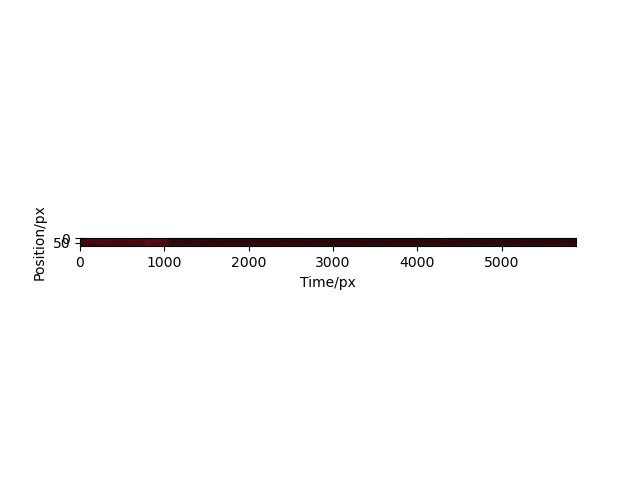

In [5]:
# show tif image
plt.figure(kymo_filename)
plt.imshow(img.astype('uint16'),vmax = 10)
plt.xlabel('Time/px')
plt.ylabel('Position/px')
plt.show()
plt.tight_layout()

In [6]:
# save .tdms file to tif image
tif.imwrite(kymo_filename + '.tiff', img)

Text(0, 0.5, 'Position/px')

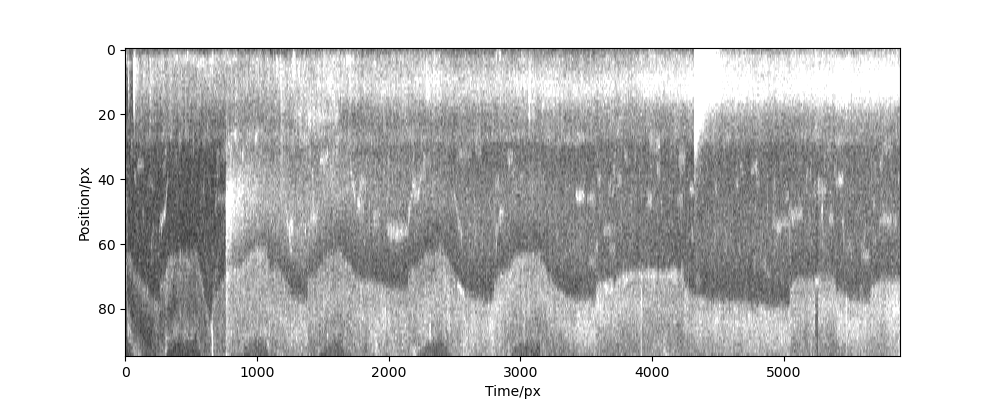

In [7]:
# Plot DNA polymerase from image data
b,g,r = cv2.split(img)

# the kymograph can be plotted in a normal image or in a reverse black-white image
vmax =15
fig, ax=plt.subplots(figsize=(10,4))
ax.imshow(g.astype('uint16'),cmap='gray',vmax = vmax,aspect ="auto")
# plt.imshow(1000-(b-g*1.2).astype('uint16'),cmap='gray',vmin = 95,aspect ="auto")

plt.xlabel("Time/px")
plt.ylabel("Position/px")
# plt.title("DNA Polymerase on ssDNA")

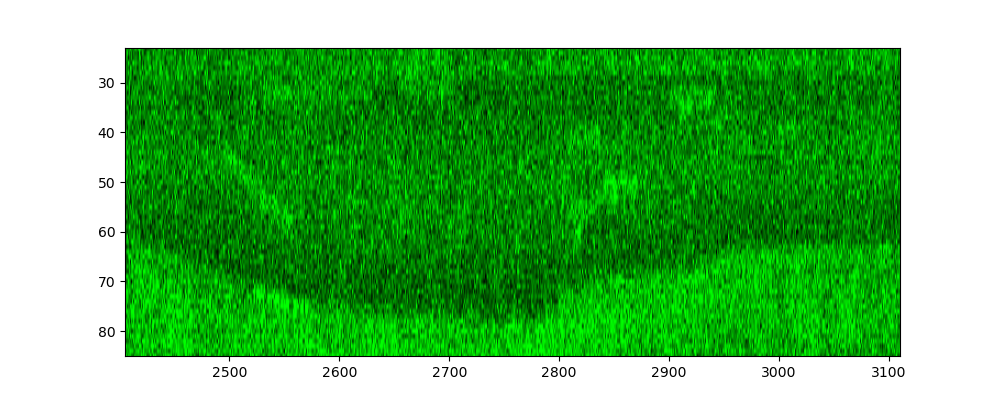

In [17]:
# Normalize the green channel by vmax
g_normalized = (g / vmax) * 255
g_normalized[g_normalized > 255] = 255

# Create a new image with only the green channel information
green_image = np.zeros_like(img)
green_image[:, :, 1] = g_normalized.astype(np.uint16)

# Plot the green image
fig, ax = plt.subplots(figsize=(10, 4))
ax.imshow(cv2.cvtColor(green_image, cv2.COLOR_BGR2RGB), aspect="auto")

# this number defines the ROI (region of interest) of image in px; should be tuned to properly display the image
kymo_xlim_left = 2405
kymo_xlim_right = 3110
kymo_ylim_top = 23
kymo_ylim_bottom = 85

ax.set_xlim(kymo_xlim_left,kymo_xlim_right)
ax.set_ylim(kymo_ylim_bottom,kymo_ylim_top)

plt.show()
plt.savefig(kymo_filename.replace('.tdms', '-cycle#') + kymo_cycle + '-splited_channel_green'+'.eps', format='eps', dpi=300, bbox_inches='tight')

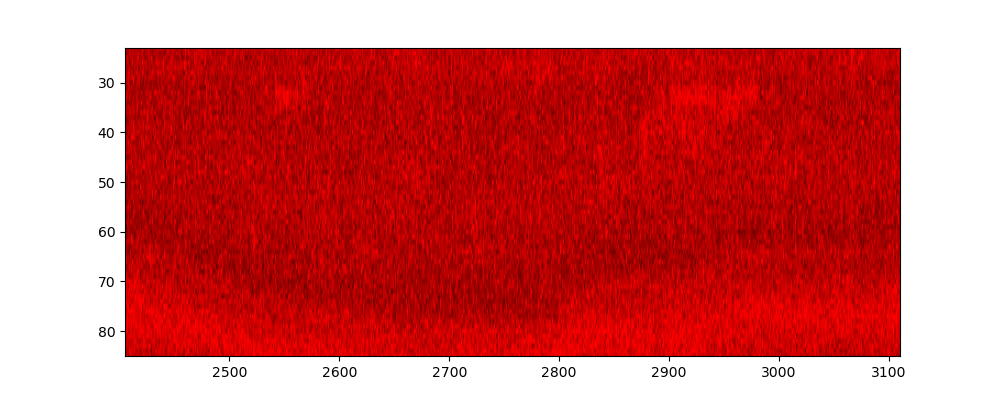

In [9]:
# Normalize the red channel by vmax
vmax_red = 60
r_normalized = (b / vmax_red) * 255
r_normalized[r_normalized > 255] = 255

# Create a new image with only the red channel information
red_image = np.zeros_like(img)
red_image[:, :, 2] = r_normalized.astype(np.uint16)

# Plot the red image
fig, ax = plt.subplots(figsize=(10, 4))
ax.imshow(cv2.cvtColor(red_image, cv2.COLOR_BGR2RGB), aspect="auto")

ax.set_xlim(kymo_xlim_left,kymo_xlim_right)
ax.set_ylim(kymo_ylim_bottom,kymo_ylim_top)
plt.show()
plt.savefig(kymo_filename.replace('.tdms', '-cycle#') + kymo_cycle + '-splited_channel_red'+'.eps', format='eps', dpi=300, bbox_inches='tight')

In [10]:
# read and plot the DNA trace calculated from force measurement (1_CalculatingDNApTrace_OT.py)

trace_file = input('please type in the file name:' )
# example name: /Users/longfu/Library/CloudStorage/Dropbox/4-T7DNAp-SSB_NSMB/Figure2_imaging data_collected_Feb &Nov_2020_analyzed_May2023/1-Thesis writing analyzing 20 molecules_23may2023/20200121-012_typical data analysis/raw data/force measurement/20200121-140145  6nM gp2.5-atto647N + 144nM wt gp2.5 + 30nM DNAp and etal #012-002-cycle#1processedData.xlsx
trace = pd.read_excel(trace_file)
# trace = pd.read_excel(trace_file, engine='openpyxl')
print(trace.head())

   Unnamed: 0    time  ssDNA_all_percentage  junction_position_all   
0           0  522299              0.045766               0.213108  \
1           1  522345              0.047335               0.220414   
2           2  522391              0.044251               0.206057   
3           3  522437              0.044763               0.208440   
4           4  522481              0.046125               0.214777   

     basepairs  
0  8008.886092  
1  7995.713544  
2  8021.599410  
3  8017.302663  
4  8005.876962  


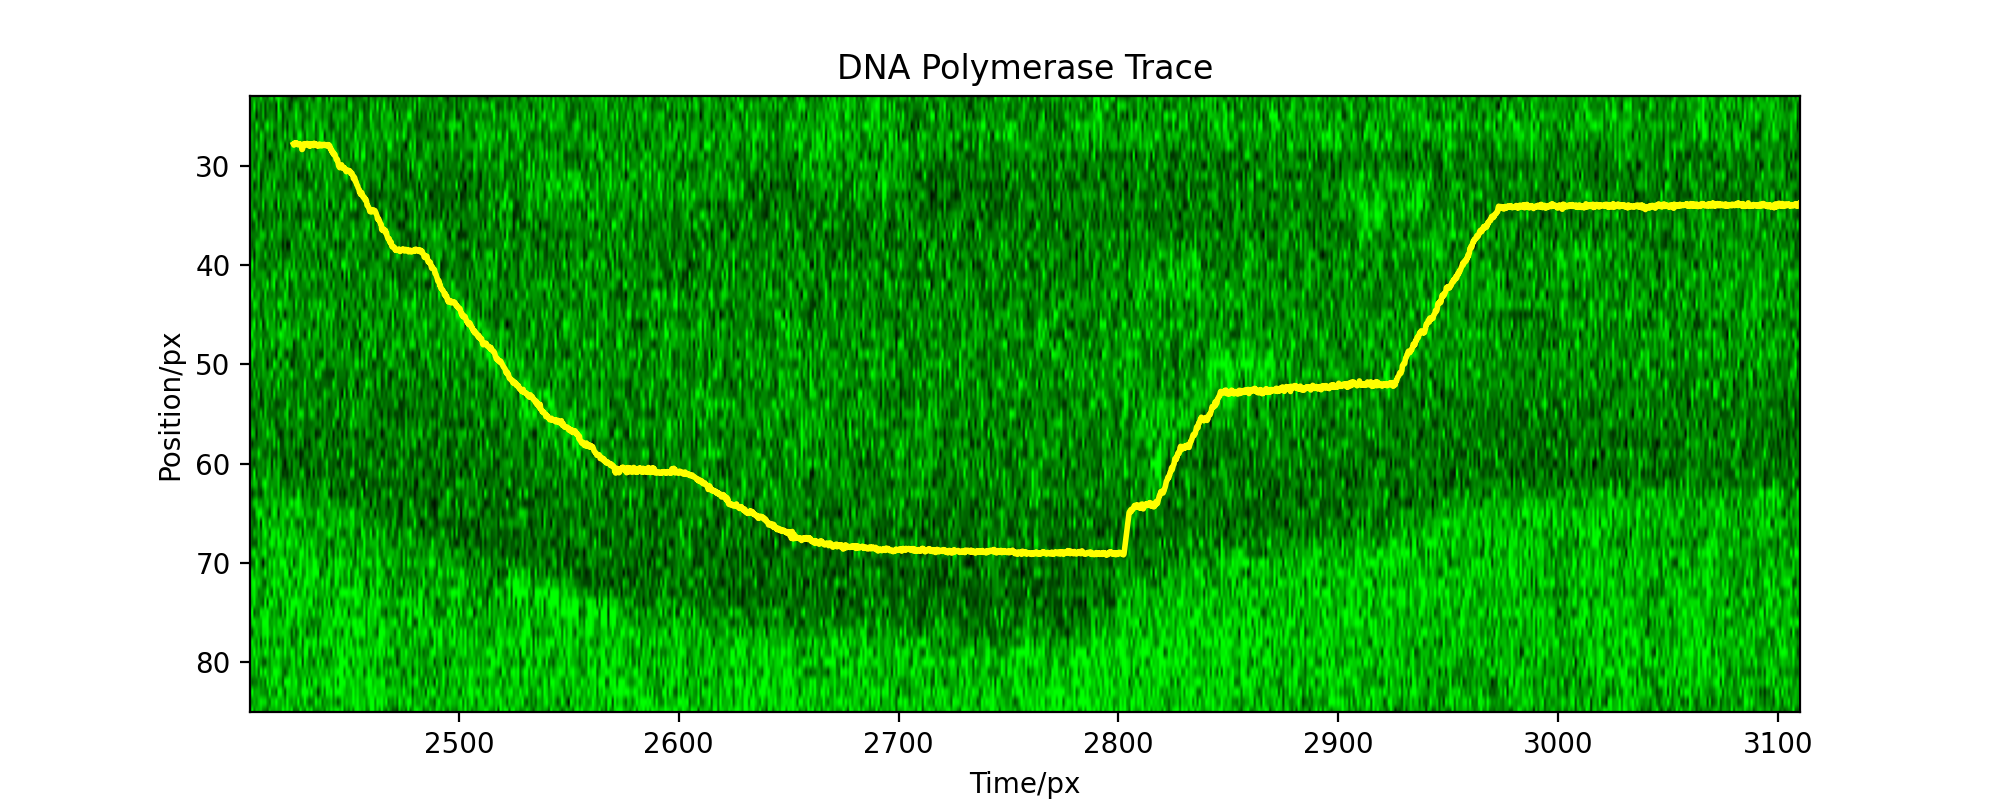

In [18]:
# the following step is intended to plot the DNA junction on top of DNAp trajectory
# The time of image is used for reference and displayed
# Tune x_offset and y_offset to get the proper alignment
# plt.figure(figsize=(8,6))
plt.xlabel("Time/px")
plt.ylabel("Position/px")
plt.title("DNA Polymerase Trace")
x_offset_searching = -25 # this is done by align starting time in pixel （larger absolute value moves to left）
y_offset_searching = 25 # this is done by align starting position in pixel 
x_cali = 1000/time_per_line  # this is calculated by (1s/time per line， e.g.：163.8ms)
y_cali = 1000/px_size # this is calculated by (1um/pixel size, in this case pixlsize = 75nm)
trace_time = trace['time']/1000 * x_cali + x_offset_searching
trace_time = trace_time.dropna()
position = pd.to_numeric(trace['junction_position_all'], errors='coerce') 
position = position * y_cali + y_offset_searching
position = position.dropna()

plt.plot(trace_time,position,'yellow',linewidth = 2, label = 'first trial correlation')
# plt.xlim(434,620)
# plt.ylim(65,13)
# plt.legend()

plt.savefig(kymo_filename.replace('.tdms', '-cycle#') + kymo_cycle + 'overlapped_DNAp_image_with_color'+'.eps', format='eps', dpi=300, bbox_inches='tight')
plt.savefig(kymo_filename.replace('.tdms', '-cycle#') + kymo_cycle + 'overlapped_DNAp_image_with_color'+'.png', format='png', dpi=300, bbox_inches='tight')
plt.show()

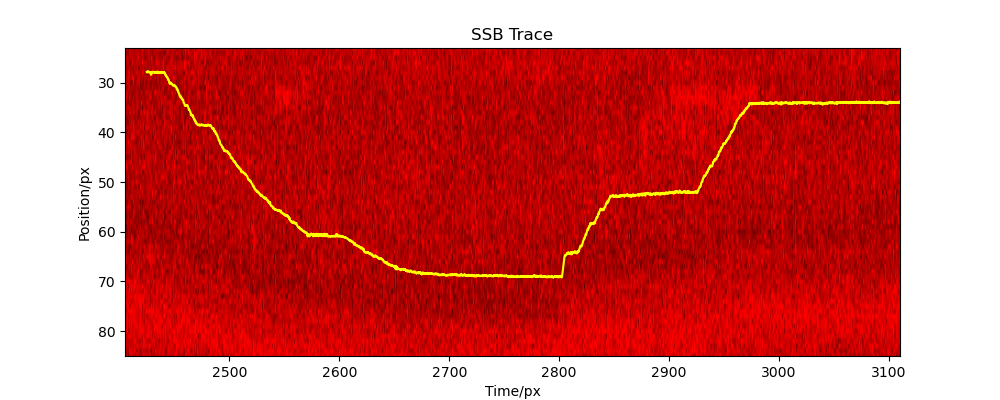

In [75]:
# the following step is intended to plot the DNA junction on top of DNAp trajectory
# The time of image is used for reference and displayed

# Normalize the red channel by vmax
r_normalized = (b / vmax_red) * 255
r_normalized[r_normalized > 255] = 255

# Create a new image with only the red channel information
red_image = np.zeros_like(img)
red_image[:, :, 2] = r_normalized.astype(np.uint16)

# Plot the red image
fig, ax = plt.subplots(figsize=(10, 4))
ax.imshow(cv2.cvtColor(red_image, cv2.COLOR_BGR2RGB), aspect="auto")
ax.set_xlim(kymo_xlim_left,kymo_xlim_right)
ax.set_ylim(kymo_ylim_bottom,kymo_ylim_top)

plt.xlabel("Time/px")
plt.ylabel("Position/px")
plt.title("SSB Trace")

ax.plot(trace_time,position,'yellow',linewidth = 1.5, label = 'first trial correlation')
# plt.xlim(434,620)
# plt.ylim(65,13)

plt.savefig(kymo_filename.replace('.tdms', '-cycle#') + kymo_cycle + 'overlapped_SSB_image_with_color'+'.eps', format='eps', dpi=300, bbox_inches='tight')
plt.savefig(kymo_filename.replace('.tdms', '-cycle#') + kymo_cycle + 'overlapped_SSB_image_with_color'+'.png', format='png', dpi=300, bbox_inches='tight')

# normally it is not necessary to do the image processing

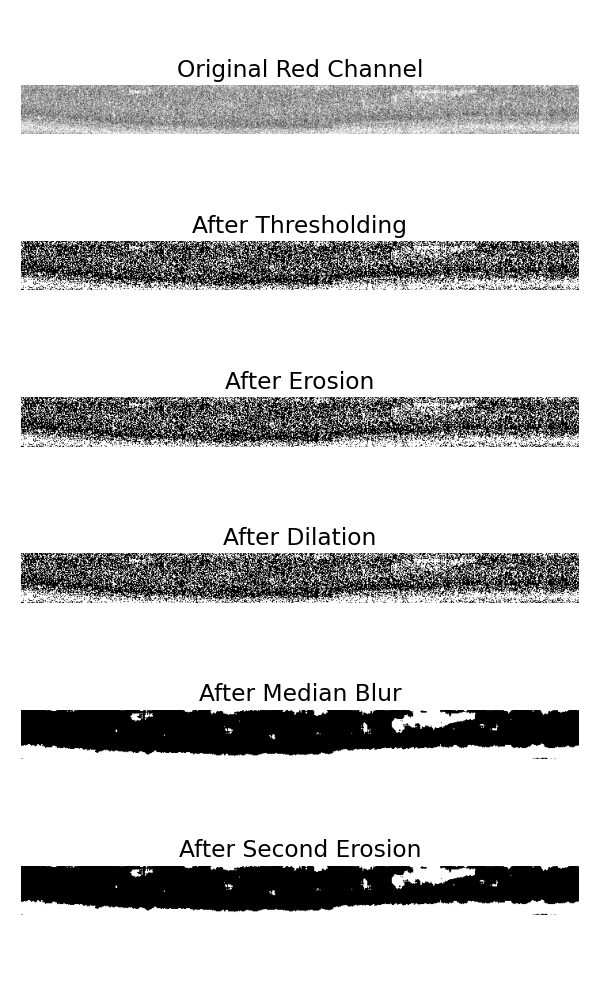

"\nHere's a brief explanation of each parameter and how you might adjust them:\n\n1. Thresholding: In the `cv2.threshold` function, `192` is the threshold value, and `255` is the maximum value that can be assigned. All pixel intensities below `192` will be set to `0` (black), and all pixel intensities above or equal to `192` will be set to `255` (white). This parameter can be adjusted according to your image. If your image has lower contrast, you might need to lower the threshold. If your image has high contrast, you might need to raise it.\n\n2. Erosion: In the `cv2.erode` function, `(2, 2)` is the size of the structuring element (a rectangle in this case) used for erosion, and `iterations=1` is the number of erosions performed. Increasing the size of the structuring element or the number of iterations will result in more erosion, which can help to remove noise but also might remove important details.\n\n3. Dilation: In the `cv2.dilate` function, `(2, 2)` is the size of the structurin

In [90]:
# Normalize the red channel by vmax
r_normalized = (b / vmax_red) * 255
r_normalized[r_normalized > 255] = 255
r_normalized_8bit = cv2.convertScaleAbs(r_normalized)

# Thresholding
_, img_threshold = cv2.threshold(r_normalized_8bit, 191, 255, cv2.THRESH_BINARY)

# Erosion
img_erosed = cv2.erode(img_threshold, np.ones((1, 1), np.uint8), iterations=1)

# Dilation
img_dilated = cv2.dilate(img_erosed, np.ones((1, 1), np.uint8), iterations=1)

# Median Blur
img_blur = cv2.medianBlur(img_dilated, 9)

# Second erosion (optional, uncomment the next line if you want to apply it)
img_erosed2 = cv2.erode(img_blur, np.ones((1, 1), np.uint8), iterations=1)

# Display the processed images
fig, axs = plt.subplots(6, 1, figsize=(6, 10))
axs[0].imshow(r_normalized_8bit, cmap='gray')
axs[0].set_title('Original Red Channel')
axs[0].axis('off')
axs[0].set_xlim(kymo_xlim_left,kymo_xlim_right)
axs[0].set_ylim(kymo_ylim_bottom,kymo_ylim_top)

axs[1].imshow(img_threshold, cmap='gray')
axs[1].set_title('After Thresholding')
axs[1].axis('off')
axs[1].set_xlim(kymo_xlim_left,kymo_xlim_right)
axs[1].set_ylim(kymo_ylim_bottom,kymo_ylim_top)

axs[2].imshow(img_erosed, cmap='gray')
axs[2].set_title('After Erosion')
axs[2].axis('off')
axs[2].set_xlim(kymo_xlim_left,kymo_xlim_right)
axs[2].set_ylim(kymo_ylim_bottom,kymo_ylim_top)

axs[3].imshow(img_dilated, cmap='gray')
axs[3].set_title('After Dilation')
axs[3].axis('off')
axs[3].set_xlim(kymo_xlim_left,kymo_xlim_right)
axs[3].set_ylim(kymo_ylim_bottom,kymo_ylim_top)

axs[4].imshow(img_blur, cmap='gray')
axs[4].set_title('After Median Blur')
axs[4].axis('off')
axs[4].set_xlim(kymo_xlim_left,kymo_xlim_right)
axs[4].set_ylim(kymo_ylim_bottom,kymo_ylim_top)

# Uncomment if you want to display img_erosed2
axs[5].imshow(img_erosed2, cmap='gray')
axs[5].set_title('After Second Erosion')
axs[5].axis('off')
axs[5].set_xlim(kymo_xlim_left,kymo_xlim_right)
axs[5].set_ylim(kymo_ylim_bottom,kymo_ylim_top)

plt.tight_layout()
plt.savefig(kymo_filename.replace('.tdms', '-cycle#') + kymo_cycle + 'SSB patch analysis'+'.eps', format='eps', dpi=300, bbox_inches='tight')
plt.savefig(kymo_filename.replace('.tdms', '-cycle#') + kymo_cycle + 'SSB patch analysis'+'.png', format='png', dpi=300, bbox_inches='tight')

plt.show()

"""
Here's a brief explanation of each parameter and how you might adjust them:

1. Thresholding: In the `cv2.threshold` function, `192` is the threshold value, and `255` is the maximum value that can be assigned. All pixel intensities below `192` will be set to `0` (black), and all pixel intensities above or equal to `192` will be set to `255` (white). This parameter can be adjusted according to your image. If your image has lower contrast, you might need to lower the threshold. If your image has high contrast, you might need to raise it.

2. Erosion: In the `cv2.erode` function, `(2, 2)` is the size of the structuring element (a rectangle in this case) used for erosion, and `iterations=1` is the number of erosions performed. Increasing the size of the structuring element or the number of iterations will result in more erosion, which can help to remove noise but also might remove important details.

3. Dilation: In the `cv2.dilate` function, `(2, 2)` is the size of the structuring element (a rectangle in this case) used for dilation, and `iterations=1` is the number of dilations performed. Increasing the size of the structuring element or the number of iterations will result in more dilation, which can help to fill in gaps but also might make features larger than they actually are.

4. Median Blur: In the `cv2.medianBlur` function, `5` is the size of the kernel used for blurring. Increasing this value will result in more blur, which can help to smooth the image and remove noise but also might blur important details.

5. Second Erosion: This is similar to the first erosion. Adjusting these parameters will have similar effects.

"""

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


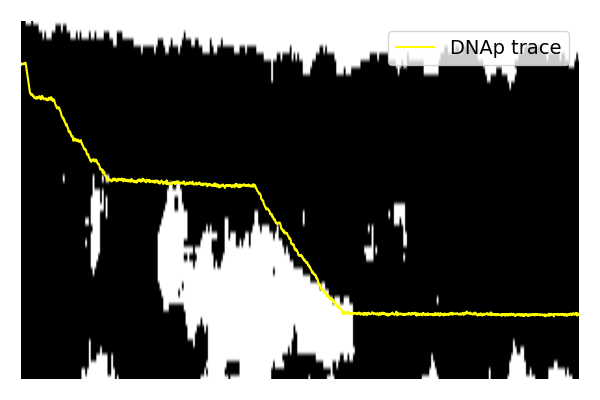

In [91]:
# Plot the red image
fig, ax = plt.subplots(figsize=(6, 4))
# Customize plot appearance
plt.rcParams.update({'font.size': 14})
plt.rcParams.update({'axes.labelsize': 14})
plt.rcParams.update({'xtick.labelsize': 12})
plt.rcParams.update({'ytick.labelsize': 12})

plt.imshow(img_blur, cmap='gray', aspect='auto')
plt.xlim(kymo_xlim_left,kymo_xlim_right)
plt.ylim(kymo_ylim_bottom,kymo_ylim_top)
plt.axis('off')
# plt.xlabel("Time/px")
plt.ylabel("Position/px")

plt.plot(trace_time,position,'yellow',linewidth = 1.5, label = 'DNAp trace')
plt.xlim(2800,3100)
plt.ylim(25,75)
plt.legend()

plt.tight_layout()
plt.savefig(kymo_filename.replace('.tdms', '-cycle#') + kymo_cycle + 'DNAP_trace_SSB patch analysis'+'.eps', format='eps', dpi=300, bbox_inches='tight')
plt.savefig(kymo_filename.replace('.tdms', '-cycle#') + kymo_cycle + 'DNAp_trace_SSB patch analysis'+'.png', format='png', dpi=300, bbox_inches='tight')

plt.show()